In [84]:
# Load our stuff
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from Bio import SeqIO
from SHMModels.simulate_mutations import *
from SHMModels.fitted_models import ContextModel
import pkgutil
import logging
import os
import sys
import json
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
random.seed(1408)
import csv
import collections
# Load options
import pandas as pd
import glob
from random import sample
from sim_data.sumstats import *
import tensorflow as tf

In [85]:
data = []
with open("./sim_data/data/data.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        data.append(row)
data = [s for s in data if len(s) == 112]
data = np.array(data)

train_X = data[data[:,111]==0][:,0:105]
train_theta = data[data[:,111]==0][:,105:111]
test_X = data[data[:,111]==1][:,0:105]
test_theta = data[data[:,111]==1][:,105:111]


x_mean = np.mean(train_X, axis =0)
x_sd = np.std(train_X, axis =0)
mean = np.mean(train_theta, axis =0)
std = np.std(train_theta, axis =0)


In [86]:
np.where([len(data[i]) != 112 for i in range(len(data))])

(array([], dtype=int64),)

In [87]:
np.concatenate((test_X,test_theta),axis = 1)

array([[ 6.72496864,  6.97114463,  5.853024  , ...,  1.28549683,
        10.49763699,  0.61160132],
       [ 2.98520621,  3.00245037,  3.05584498, ..., 17.28095513,
         7.08313736,  0.18201618],
       [ 6.50444703,  4.59516272,  6.3532292 , ..., 10.81777736,
         2.9053945 ,  0.99046873],
       ...,
       [ 2.67884852,  2.75874972,  2.83870404, ...,  6.12994466,
         8.06007331,  0.22899819],
       [10.23678436,  6.90436034,  5.74650016, ..., 12.91124467,
         7.82761891,  0.5657658 ],
       [ 7.11284385,  4.75121625,  3.75017202, ..., 16.39887829,
         9.20869646,  0.69001641]])

In [88]:
data = pd.DataFrame(np.concatenate((test_X,test_theta,np.ones((910,1))),axis = 1))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 860 and the array at index 2 has size 910

In [ ]:
data = data.append(pd.DataFrame(np.concatenate((train_X[0:9100,:],train_theta,np.zeros((9100,1))),axis = 1)))

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [ ]:
data.iloc[:,111]

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
9095    0.0
9096    0.0
9097    0.0
9098    0.0
9099    0.0
Name: 111, Length: 10010, dtype: float64

In [ ]:
data.iloc[:,0:105][data.iloc[:,111] == 1]

0          1          2         3         4         5         6    \
0     4.097395   4.668972   4.251317  4.639262  4.519867  4.275166  4.195679   
1     2.944342   2.251728   2.204092  1.956727  1.868405  2.127003  1.715472   
2    11.295523   4.476271   2.352213  2.362103  1.217787  1.668543  2.289403   
3     4.275074   4.804425   4.960873  4.472161  3.661548  5.507837  4.465074   
4    21.805218  20.377148  13.488461  9.471836  6.082470  9.277316  6.085583   
..         ...        ...        ...       ...       ...       ...       ...   
905   5.026869   4.942875   3.925218  3.720662  3.547638  3.897832  2.728186   
906   5.512978   7.220651   6.399333  4.490456  5.389640  5.831324  5.193320   
907   5.146622   4.101983   5.056517  3.653960  3.964333  4.714870  3.621251   
908   4.253594   5.016659   3.833686  3.567027  4.141159  3.241230  3.098694   
909  10.091071   6.475492   5.681240  6.228569  4.188262  6.133247  3.886563   

          7         8         9    ...       95        96        97   \
0    4.286301  4.220491  4.072984  ...  0.585000  0.619413  0.321363   
1    1.930700  1.710497  1.678746  ...  0.904304  0.919151  0.913874   
2    1.905351  1.803336  1.936547  ...  0.988213  1.063208  1.551374   
3    3.695780  4.088912  4.164413  ...  0.390125  0.307398  0.352497   
4    3.798141  2.516673  2.648737  ...  0.229162  0.170443  1.242293   
..        ...       ...       ...  ...       ...       ...       ...   
905  3.208884  3.914489  3.568508  ...  0.335491  0.319933  0.544142   
906  4.508059  3.982944  4.822059  ...  0.284397  0.230363  0.433161   
907  3.462601  3.763145  3.191638  ...  0.518012  0.609153  0.472926   
908  2.641541  2.995149  2.602610  ...  0.608054  0.732950  0.652112   
909  4.560501  3.114756  4.077337  ...  0.896308  0.216808  0.311149   

          98        99        100        101       102       103       104  
0    0.406133  0.457392  1.183989  71.325284  0.328464  0.016668  0.510586  
1    0.863545  0.883938  1.188162  81.463476  0.395794  0.020386  0.406596  
2    0.930934  0.590774  1.200669  24.744986  0.655613  0.004720  0.192841  
3    0.299338  0.366503  1.141774  53.098188  0.932947  0.009333  0.214437  
4    0.146635  0.010833  1.046512  11.342105  0.388590  0.002967  0.044239  
..        ...       ...       ...        ...       ...       ...       ...  
905  0.446942  0.386213  1.152973  67.541192  0.241105  0.006476  0.436424  
906  0.195820  0.583716  1.167732  49.530414  0.825619  0.006910  0.447896  
907  0.519170  0.453054  1.191781  64.544474  0.215275  0.022478  0.255675  
908  0.819781  0.796723  1.172486  86.481265  0.435724  0.015392  0.706950  
909  0.949294  0.278197  1.199380  60.164228  0.248753  0.005402  0.546893  

[910 rows x 105 columns]

In [90]:
model = keras.models.load_model('preds/model')

In [7]:
df = pd.read_pickle("sim_data/data/full_edge_df.pk1")
parent_sample= list(df['orig_seq'])
obs_sample = list(df['mut_seq'])
colocals = colocal_vector(parent_sample, obs_sample)
exo = np.concatenate([get_exo_summ(obs_sample[i],parent_sample[i]) for i in range(len(parent_sample))]).ravel().tolist()
at = np.concatenate([get_pairwise_at(obs_sample[i],parent_sample[i]) for i in range(len(parent_sample))]).ravel().tolist()
c_counts, g_counts = get_cg_summ_sample(obs_sample,parent_sample)
bp = base_prob(obs_sample,parent_sample)
atp = at_frac(obs_sample,parent_sample)
summ_stat = np.append(colocals,[np.mean(exo),np.mean(at), np.sum(c_counts)/(np.sum(c_counts) + np.sum(g_counts)), bp,atp])

In [8]:
summ_stat_cent = (summ_stat-x_mean)/x_sd


In [91]:
params = model.predict(summ_stat_cent.reshape(1,105))*std + mean

1/1 [==============================] - 0s 56ms/step


In [92]:
params = params[0]
params

array([-9.71396504,  6.9732454 ,  0.51655939, 18.22189314, 14.75165542,
        0.657664  ])

In [93]:
train_X[:,102]

array([0.43536217, 0.5995935 , 0.49510124, ..., 0.12206729, 0.48564295,
       0.7520429 ])

In [94]:
lower = np.zeros(100)
upper = np.zeros(100)

for i in range(100):
    lower[i] = np.quantile(train_X[:,i],0.1)
    upper[i] = np.quantile(train_X[:,i],0.90)

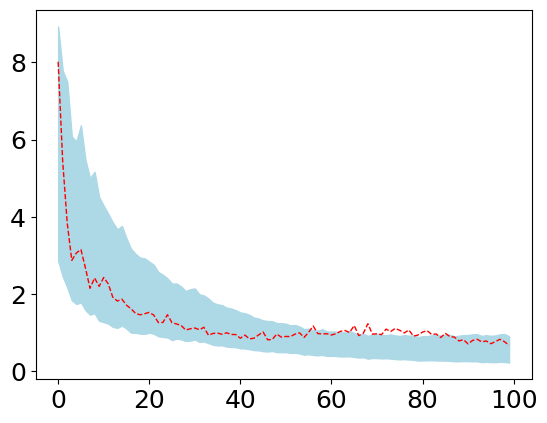

In [95]:
plt.fill_between(range(100),lower,upper, color = 'lightblue')
plt.plot(summ_stat[0:100], color='red', linestyle='dashed', linewidth=1)

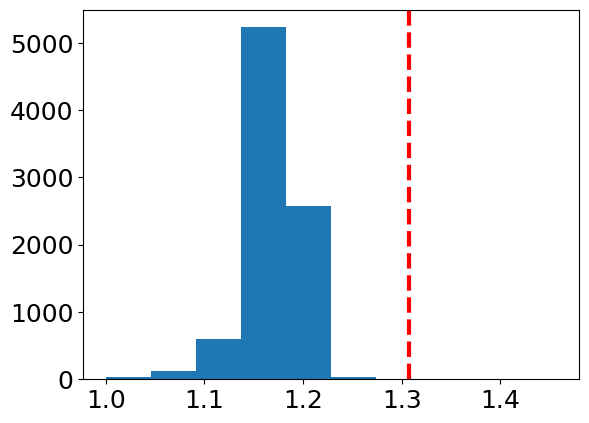

In [96]:
plt.hist(train_X[:,100])
plt.axvline(summ_stat[100], color='red', linestyle='dashed', linewidth=3)

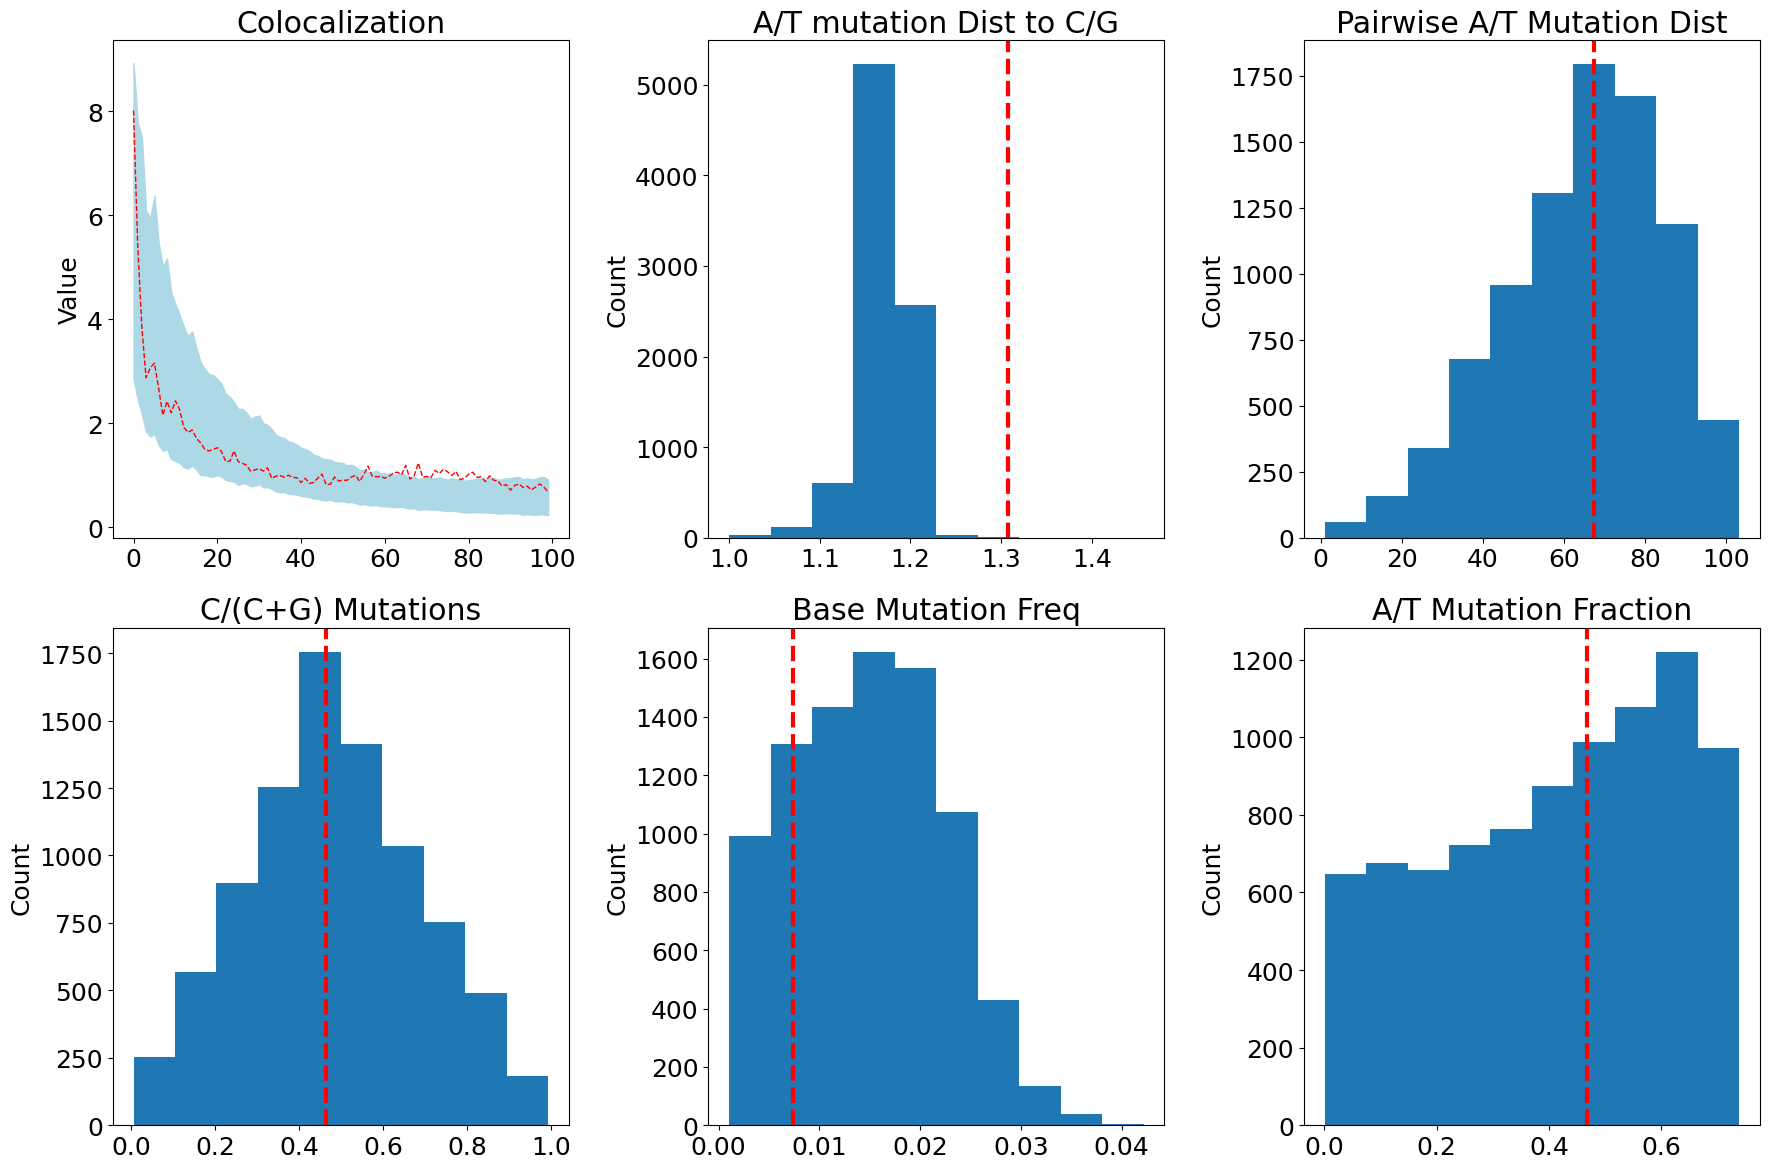

In [97]:
plt.rcParams.update({'font.size': 18})
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 3)
  
# For Sine Function
axis[0, 0].fill_between(range(100),lower,upper, color = 'lightblue')
axis[0,0].plot(summ_stat[0:100], color='red', linestyle='dashed', linewidth=1)
axis[0, 0].set_title("Colocalization")
axis[0, 0].set_ylabel("Value")
# For Cosine Function
axis[0, 1].hist(train_X[:,100])
axis[0, 1].axvline(summ_stat[100], color='red', linestyle='dashed', linewidth=3)
axis[0, 1].set_title("A/T mutation Dist to C/G")
axis[0, 1].set_ylabel("Count")
# For Cosine Function
axis[0, 2].hist(train_X[:,101])
axis[0, 2].axvline(summ_stat[101], color='red', linestyle='dashed', linewidth=3)
axis[0, 2].set_title("Pairwise A/T Mutation Dist")
axis[0, 2].set_ylabel("Count")
# For Cosine Function
axis[1, 0].hist(train_X[:,102])
axis[1, 0].axvline(summ_stat[102], color='red', linestyle='dashed', linewidth=3)
axis[1, 0].set_title("C/(C+G) Mutations")
axis[1, 0].set_ylabel("Count")
# For Cosine Function
axis[1, 1].hist(train_X[:,103])
axis[1, 1].axvline(summ_stat[103], color='red', linestyle='dashed', linewidth=3)
axis[1, 1].set_title("Base Mutation Freq")
axis[1, 1].set_ylabel("Count")
# For Cosine Function
axis[1, 2].hist(train_X[:,104])
axis[1, 2].axvline(summ_stat[104], color='red', linestyle='dashed', linewidth=3)
axis[1, 2].set_title("A/T Mutation Fraction")
axis[1, 2].set_ylabel("Count")
figure.set_figheight(12)
figure.set_figwidth(18)
figure.tight_layout(pad=1.0)
# Combine all the operations and display
plt.savefig('figures/summ_stat.pdf', format = 'pdf')
plt.show()

In [122]:
params

array([-9.71396504,  6.9732454 ,  0.51655939, 18.22189314, 14.75165542,
        0.657664  ])

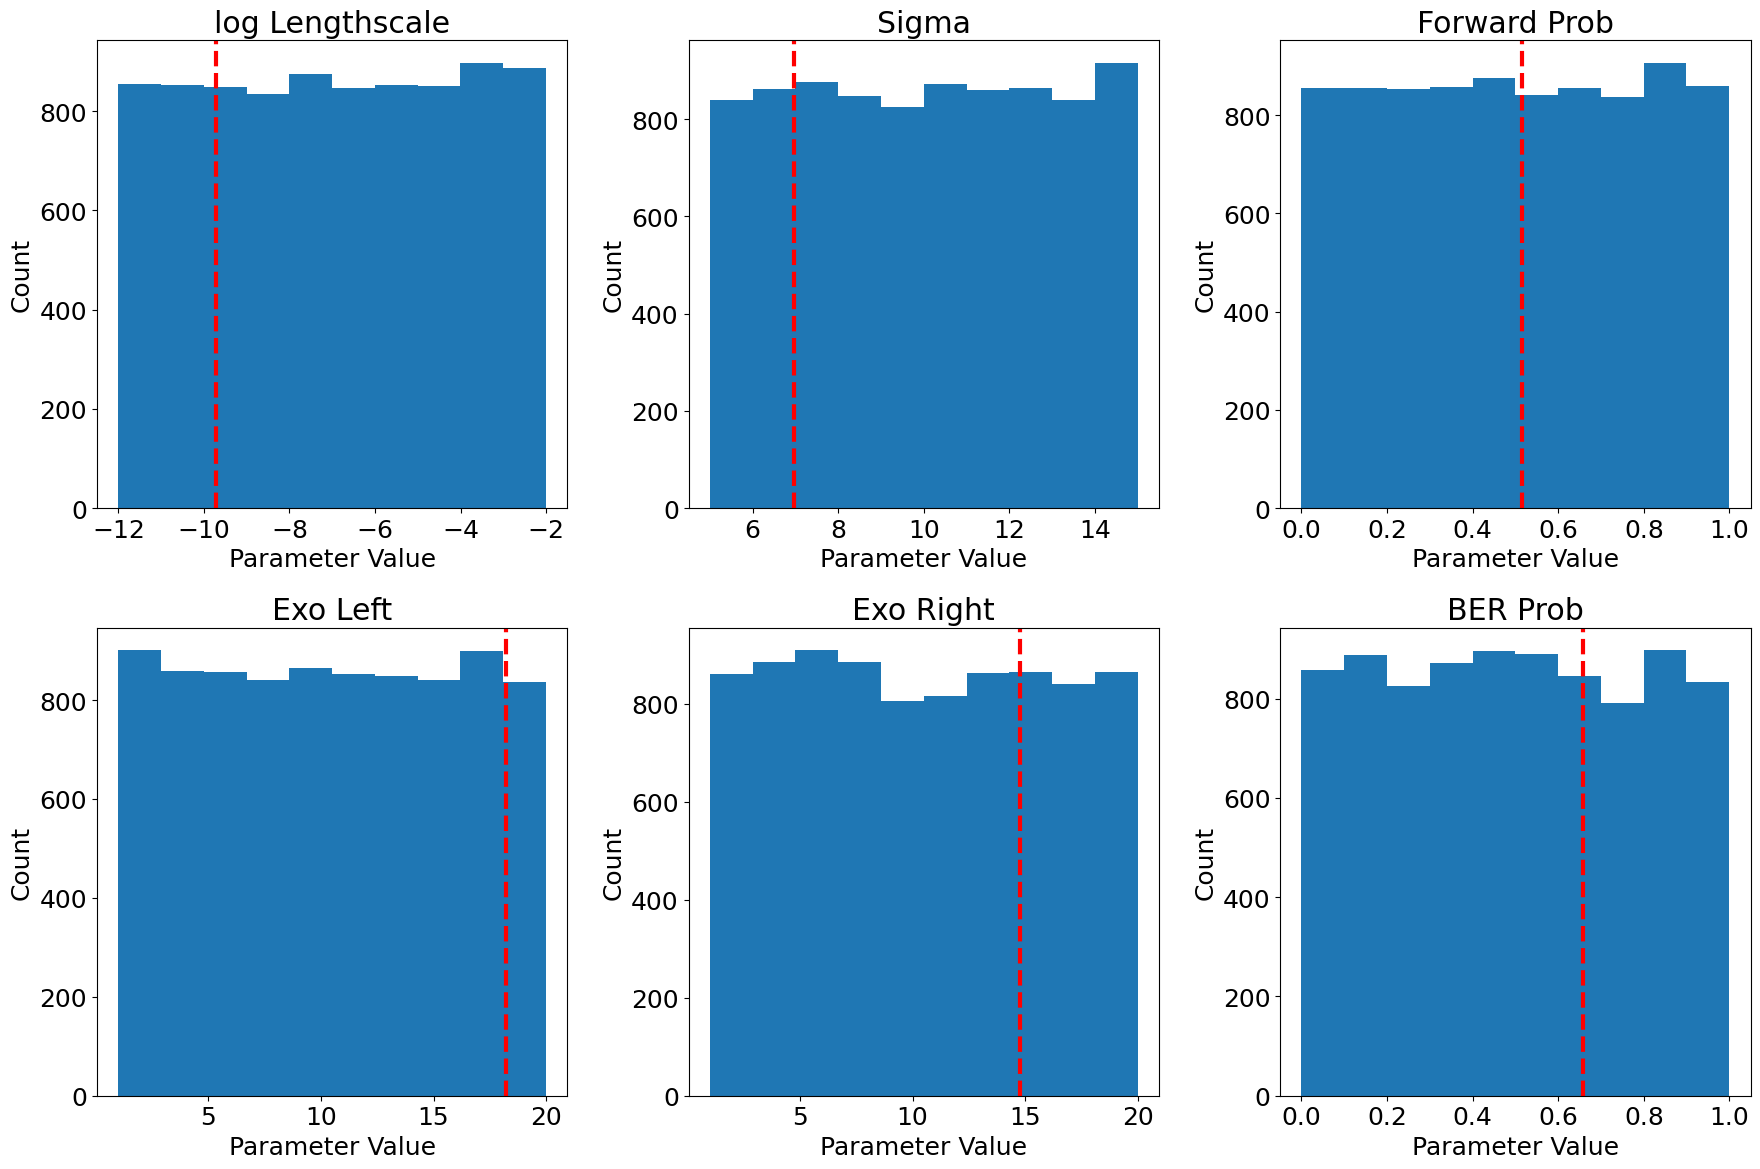

In [69]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 3)
# For Sine Function
axis[0, 0].hist(train_theta[:,0])
axis[0, 0].axvline(params[0], color='red', linestyle='dashed', linewidth=3)
axis[0, 0].set_title("log Lengthscale")
axis[0, 0].set_ylabel("Count")
axis[0, 0].set_xlabel("Parameter Value")
# For Sine Function
axis[0, 1].hist(train_theta[:,1])
axis[0, 1].axvline(params[1], color='red', linestyle='dashed', linewidth=3)
axis[0, 1].set_title("Sigma")
axis[0, 1].set_ylabel("Count")
axis[0, 1].set_xlabel("Parameter Value") 
# For Cosine Function# For Sine Function
axis[0, 2].hist(train_theta[:,2])
axis[0, 2].axvline(params[2], color='red', linestyle='dashed', linewidth=3)
axis[0, 2].set_title("Forward Prob")
axis[0, 2].set_ylabel("Count")
axis[0, 2].set_xlabel("Parameter Value")  
# For Cosine Function# For Sine Function
axis[1, 0].hist(train_theta[:,3])
axis[1, 0].axvline(params[3], color='red', linestyle='dashed', linewidth=3)
axis[1, 0].set_title("Exo Left")
axis[1, 0].set_ylabel("Count")
axis[1, 0].set_xlabel("Parameter Value")  
# For Cosine Function# For Sine Function
axis[1, 1].hist(train_theta[:,4])
axis[1, 1].axvline(params[4], color='red', linestyle='dashed', linewidth=3)
axis[1, 1].set_title("Exo Right")
axis[1, 1].set_ylabel("Count")
axis[1, 1].set_xlabel("Parameter Value")  
# For Cosine Function# For Sine Function
axis[1, 2].hist(train_theta[:,5])
axis[1, 2].axvline(params[5], color='red', linestyle='dashed', linewidth=3)
axis[1, 2].set_title("BER Prob")
axis[1, 2].set_ylabel("Count")
axis[1, 2].set_xlabel("Parameter Value")
  
# For Cosine Function
figure.set_figheight(12)
figure.set_figwidth(18)
figure.tight_layout(pad=1.0)
# Combine all the operations and display
plt.savefig('figures/real_hist.pdf', format = 'pdf')
plt.show()

In [70]:
data = pd.read_csv('data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R.csv')

In [79]:
np.savetxt('branch_lengths',data['branch_length'])

(array([8.3331e+04, 9.1300e+02, 3.7000e+01, 1.3000e+01, 1.1000e+01,
        9.0000e+00, 2.0000e+00, 4.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([6.80700000e-07, 7.68837731e-02, 1.53766865e-01, 2.30649958e-01,
        3.07533050e-01, 3.84416143e-01, 4.61299235e-01, 5.38182327e-01,
        6.15065420e-01, 6.91948512e-01, 7.68831605e-01]),
 <BarContainer object of 10 artists>)

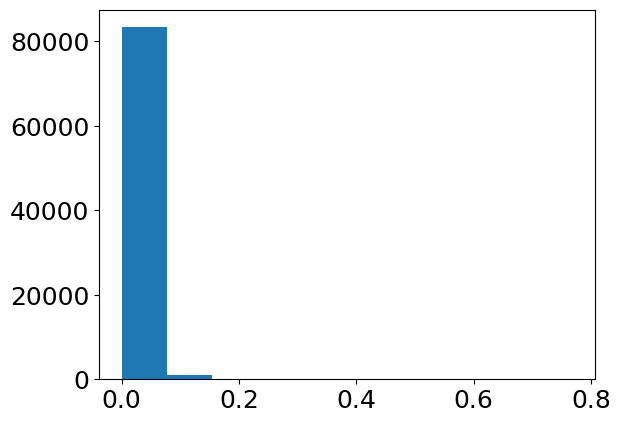

In [73]:
plt.hist(data['branch_length'])

In [15]:
preds = np.load('preds/preds_0.npy')
labels = np.load('preds/labels_0.npy')

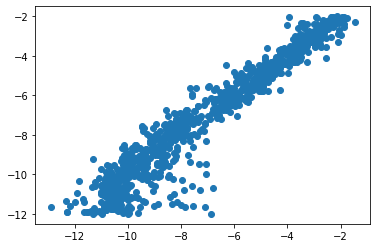

In [91]:
plt.scatter(preds[:,0],labels[:,0])

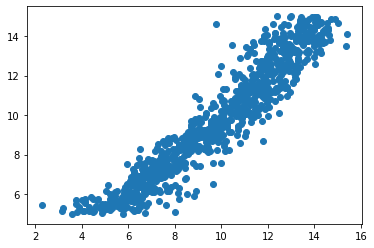

In [92]:
plt.scatter(preds[:,1],labels[:,1])

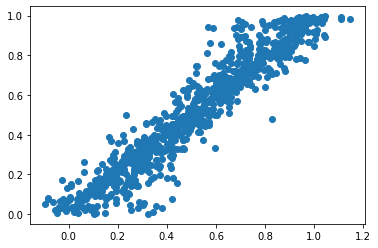

In [93]:
plt.scatter(preds[:,2],labels[:,2])

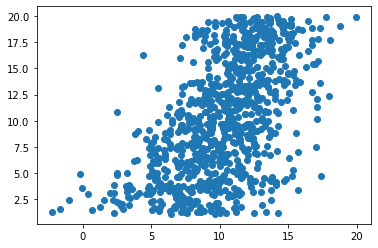

In [94]:
plt.scatter(preds[:,3],labels[:,3])

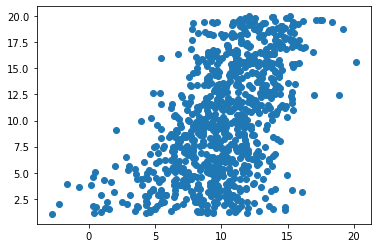

In [95]:
plt.scatter(preds[:,4],labels[:,4])

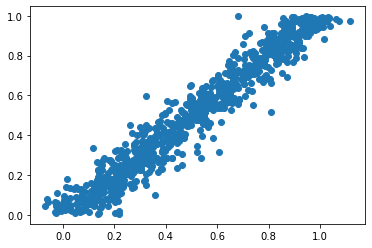

In [96]:
plt.scatter(preds[:,5],labels[:,5])

In [29]:
import csv
data = []
with open("sim_data/data.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        data.append(row)

In [23]:
len(train_X[:,0])

9100

In [24]:
data[data[:,111]==0][0,105:112]

TypeError: list indices must be integers or slices, not tuple

In [40]:
axis[0,0].get_yticks()

array([-14., -12., -10.,  -8.,  -6.,  -4.,  -2.])

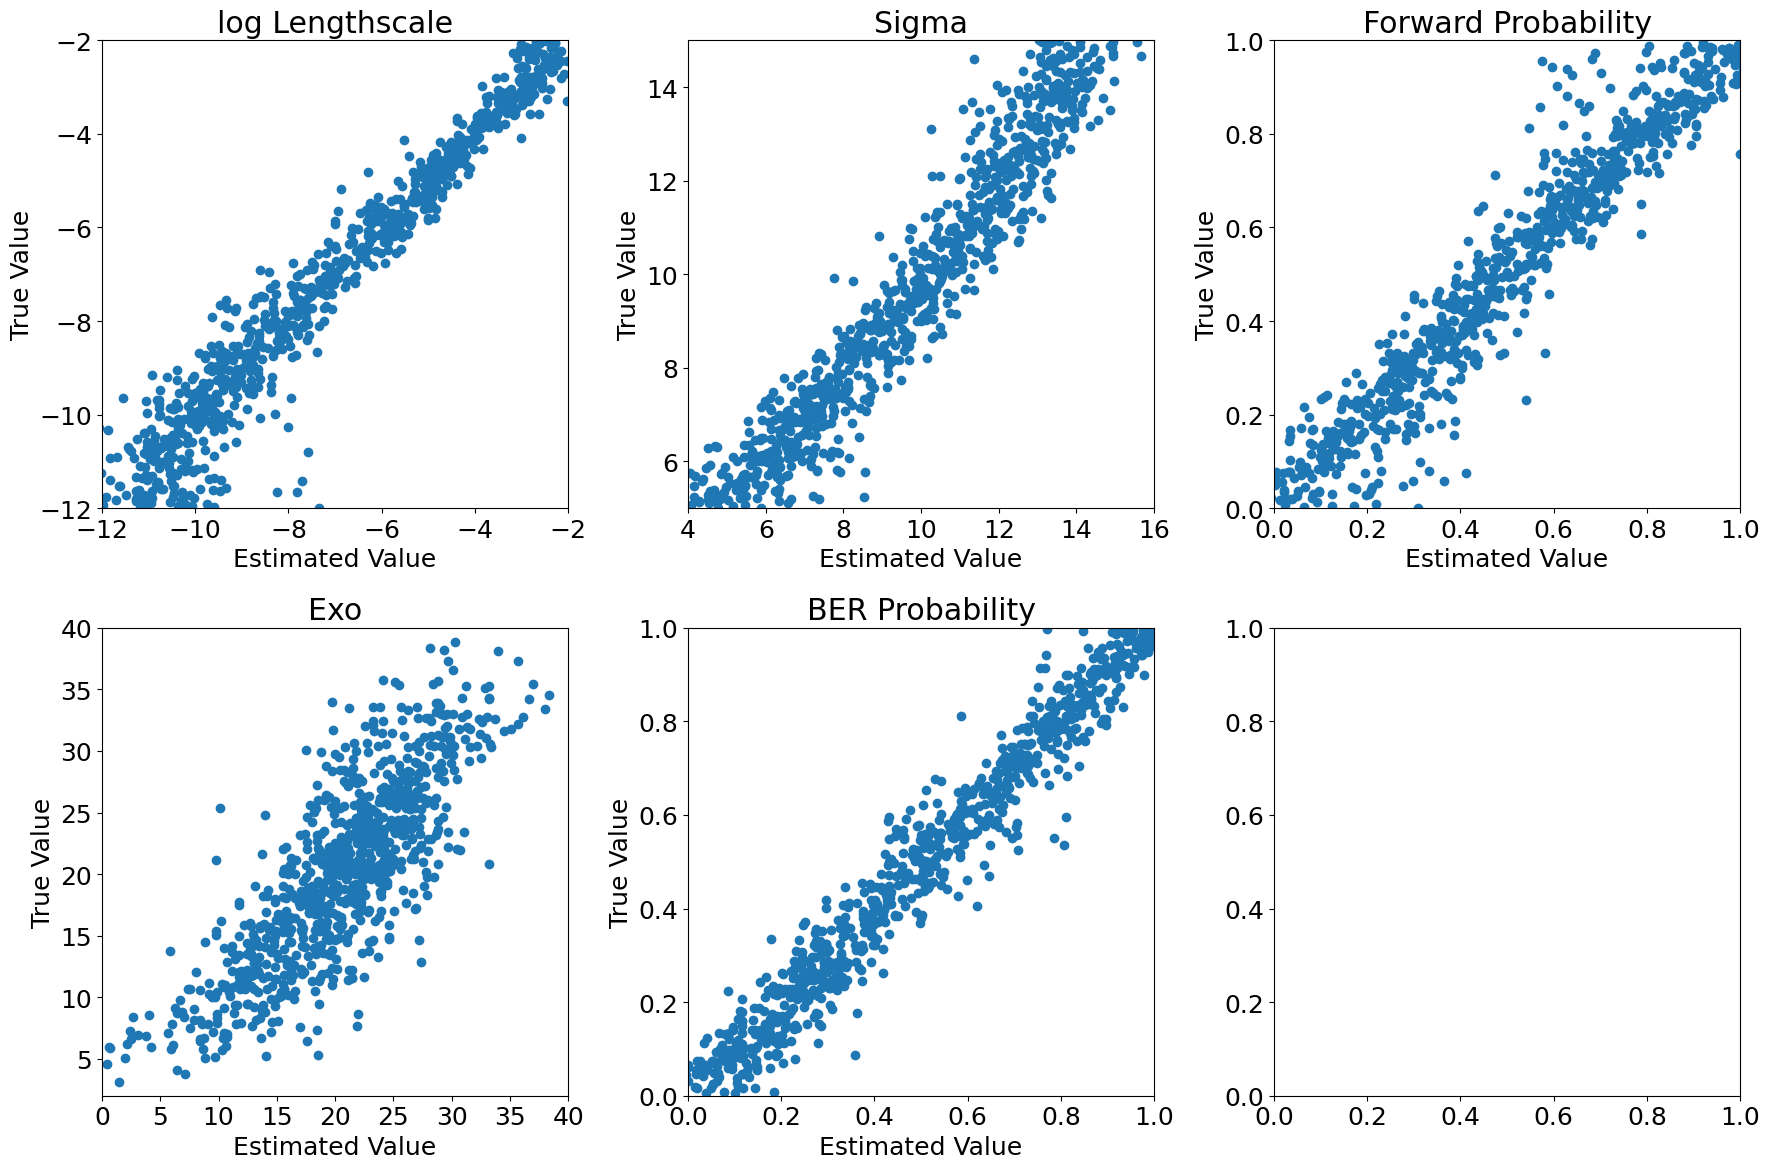

In [45]:
from matplotlib.ticker import StrMethodFormatter

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 3)

# For Sine Function
axis[0, 0].scatter(preds[:,0], labels[:,0])
axis[0, 0].set_title("log Lengthscale")
axis[0, 0].set_xlabel("Estimated Value")
axis[0, 0].set_ylabel("True Value")
axis[0,0].set_xlim(-12,-2)
axis[0,0].set_ylim(-12,-2)

# For Cosine Function
axis[0, 1].scatter(preds[:,1], labels[:,1])
axis[0, 1].set_title("Sigma")
axis[0, 1].set_xlabel("Estimated Value")
axis[0, 1].set_ylabel("True Value")
axis[0,1].set_xlim(5,15)
axis[0,1].set_ylim(5,15)
# For Tangent Function
axis[0, 2].scatter(preds[:,2], labels[:,2])
axis[0, 2].set_title("Forward Probability")
axis[0, 2].set_xlabel("Estimated Value")
axis[0, 2].set_ylabel("True Value")
axis[0,2].set_xlim(0,1)
axis[0,2].set_ylim(0,1)  
# For Sine Function
axis[1, 0].scatter(preds[:,3]+preds[:,4], labels[:,3]+labels[:,4])
axis[1, 0].set_title("Exo")
axis[1, 0].set_xlabel("Estimated Value")
axis[1, 0].set_ylabel("True Value")  
axis[1,0].set_xlim(2,40)
axis[1,0].set_ylim(2,40)  
# For Tangent Function
axis[1, 1].scatter(preds[:,5], labels[:,5])
axis[1, 1].set_title("BER Probability")
axis[1, 1].set_xlabel("Estimated Value")
axis[1, 1].set_ylabel("True Value")
axis[1,1].set_xlim(0,1)
axis[1,1].set_ylim(0,1)
figure.set_figheight(12)
figure.set_figwidth(18)
figure.tight_layout(pad=1.0)

yticks = axis[0,0].get_yticks()
axis[0,0].set_xticks(yticks)
yticks = axis[0,1].get_yticks()
axis[0,1].set_xticks(yticks)
yticks = axis[1,0].get_yticks()
axis[1,0].set_xticks(yticks)
yticks = axis[0,2].get_yticks()
axis[0,2].set_xticks(yticks)
yticks = axis[1,1].get_yticks()
axis[1,1].set_xticks(yticks)
# Combine all the operations and display
plt.savefig('figures/scatter.svg', format = 'svg')
plt.show()


In [28]:
np.corrcoef(preds[:,3], labels[:,3])**2

array([[1.        , 0.27162282],
       [0.27162282, 1.        ]])

In [61]:
data = []
with open("sim_data/data/data.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        data.append(row)
data = [s for s in data if len(s) == 112]
data = np.array(data)
train_X = data[data[:,111]==0][:,0:105]
train_theta = data[data[:,111]==0][:,105:111]
test_X = data[data[:,111]==1][:,0:105]
test_theta = data[data[:,111]==1][:,105:111]


x_mean = np.mean(train_X, axis =0)
x_sd = np.std(train_X, axis =0)
mean = np.mean(train_theta, axis =0)
std = np.std(train_theta, axis =0)
# Center labels
train_cent = (train_theta - mean)/std
test_cent = (test_theta - mean)/std
# Center training data
train_X = (train_X-x_mean)/x_sd
test_X =  (test_X - x_mean)/x_sd
# Get length of training data
train_n = np.shape(train_X)[0]

In [62]:
shuffle = []
for i in range(7):
    t_x = test_X.copy()
    t_c = test_cent.copy()
    if i == 0:
        pass
    elif i == 1:
        for j in range(100):
            random.shuffle(t_x[:,j])
    else:
        random.shuffle(t_x[:,98+i])
    shuffle.append(np.mean((model.predict(t_x)-t_c)**2, axis = 0))

27/27 [==============================] - 0s 778us/step


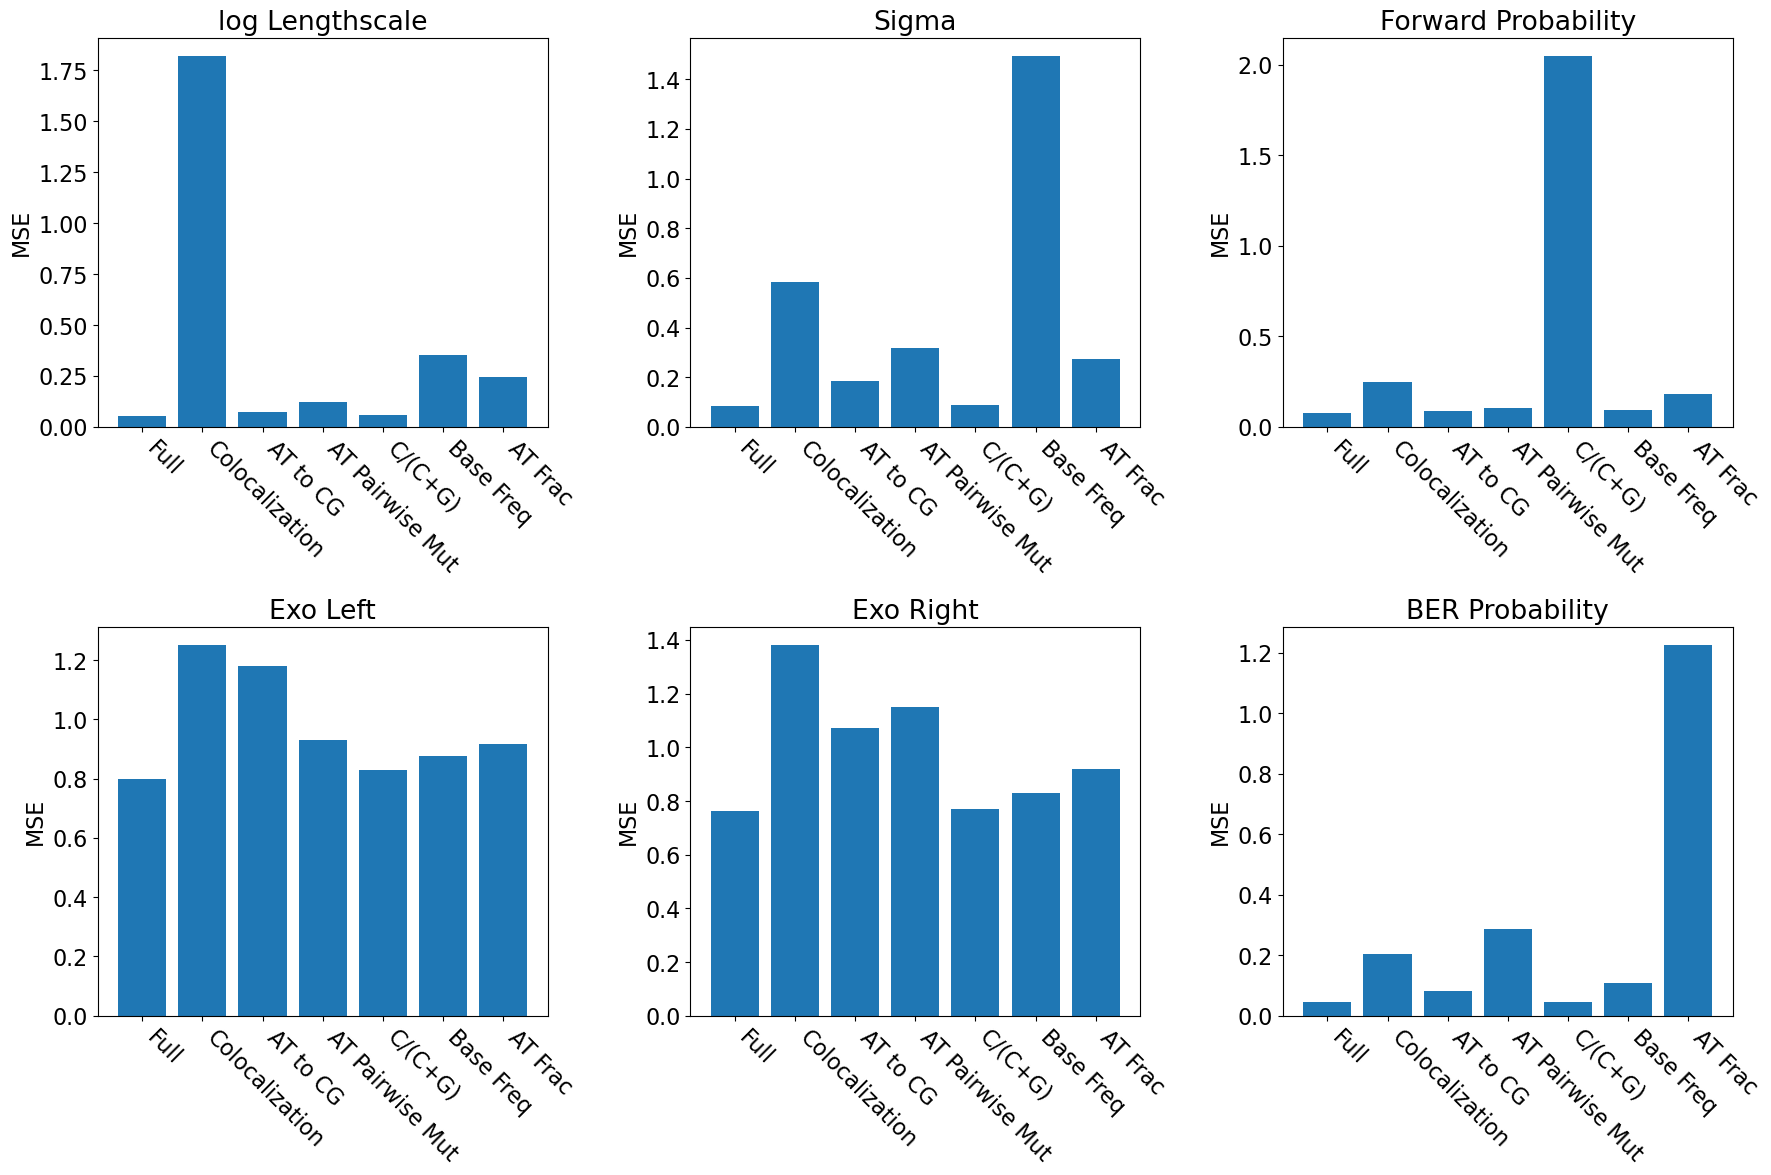

In [66]:
plt.rcParams.update({'font.size': 16})
hist_labels = ['Full', 'Colocalization', 'AT to CG', 'AT Pairwise Mut','C/(C+G)','Base Freq','AT Frac']
y_pos = range(len(hist_labels))
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 3)
  
# For Sine Function
axis[0, 0].bar(y_pos,[shuffle[i][0] for i in range(7)])
axis[0, 0].set_title("log Lengthscale")
axis[0,0].set_xticks(y_pos, hist_labels, rotation=-45, ha = 'left')
axis[0,0].set_ylabel('MSE')
# For Cosine Function
axis[0, 1].bar(y_pos,[shuffle[i][1] for i in range(7)])
axis[0, 1].set_title("Sigma")
axis[0,1].set_xticks(y_pos, hist_labels, rotation=-45, ha = 'left')
axis[0,1].set_ylabel('MSE')
# For Tangent Function
axis[0, 2].bar(y_pos,[shuffle[i][2] for i in range(7)])
axis[0, 2].set_title("Forward Probability")
axis[0,2].set_xticks(y_pos, hist_labels, rotation=-45, ha = 'left')
axis[0,2].set_ylabel('MSE')
# For Sine Function
axis[1, 0].bar(y_pos,[shuffle[i][3] for i in range(7)])
axis[1, 0].set_title("Exo Left")
axis[1,0].set_xticks(y_pos, hist_labels, rotation=-45, ha = 'left')
axis[1,0].set_ylabel('MSE')
# For Cosine Function
axis[1, 1].bar(y_pos,[shuffle[i][4] for i in range(7)])
axis[1, 1].set_title("Exo Right")
axis[1,1].set_xticks(y_pos, hist_labels, rotation=-45, ha = 'left')
axis[1,1].set_ylabel('MSE')
# For Tangent Function
axis[1, 2].bar(y_pos,[shuffle[i][5] for i in range(7)])
axis[1, 2].set_title("BER Probability")
axis[1,2].set_xticks(y_pos, hist_labels, rotation=-45, ha = 'left')
axis[1,2].set_ylabel('MSE')
figure.set_figheight(12)
figure.set_figwidth(18)
figure.tight_layout(pad=1.0)
# Combine all the operations and display
plt.savefig('figures/var_imp.pdf', format = 'pdf')
plt.show()

In [25]:
np.std(train_X, axis =0)

array([2.88424117e+00, 2.30133878e+00, 2.17435839e+00, 1.71882336e+00,
       1.67730199e+00, 1.86240195e+00, 1.55836728e+00, 1.40141528e+00,
       1.45213297e+00, 1.26482567e+00, 1.19081987e+00, 1.13737806e+00,
       1.07186485e+00, 1.01321821e+00, 1.02771820e+00, 9.51972662e-01,
       8.72856052e-01, 8.23107900e-01, 7.93194887e-01, 7.88571217e-01,
       7.64727143e-01, 7.21376635e-01, 6.81462358e-01, 6.58671799e-01,
       6.28989801e-01, 5.98747277e-01, 5.85864820e-01, 5.54400240e-01,
       5.28929783e-01, 5.35376360e-01, 5.23309208e-01, 4.96414328e-01,
       4.80072186e-01, 4.55588977e-01, 4.31467369e-01, 4.15144630e-01,
       4.04297939e-01, 3.89384312e-01, 3.79864703e-01, 3.75876707e-01,
       3.57151459e-01, 3.48250442e-01, 3.39544193e-01, 3.20657670e-01,
       3.13911523e-01, 3.06770423e-01, 3.05234220e-01, 3.01733395e-01,
       2.90477224e-01, 2.86099960e-01, 2.83558335e-01, 2.76276449e-01,
       2.78340745e-01, 2.71465426e-01, 2.58719679e-01, 2.62120120e-01,
      

In [64]:
np.shape(test_X)

(900, 105)

In [3]:
pd.read_csv('../kevin_data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R.csv')

Unnamed: 0  sample_id  family  \
0               0     316188    1810   
1               1     316188    1810   
2               2     316188    1810   
3               3     316188    1810   
4               4     316188    1810   
...           ...        ...     ...   
84317       84317     326713    7218   
84318       84318     326713    7218   
84319       84319     326713    7218   
84320       84320     326713    7218   
84321       84321     326713    7218   

                                                orig_seq  \
0      CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...   
1      CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...   
2      CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...   
3      CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...   
4      CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...   
...                                                  ...   
84317  GAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTTCAGCCTGGGG...   
84318  GAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTTCAGCCTGGGG...   
84319  GAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTTCAGCCTGGGG...   
84320  GAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTTCAGCCTGGGG...   
84321  GAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTTCAGCCTGGGG...   

                                                 mut_seq  branch_length  \
0      CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...   9.965000e-07   
1      CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...   9.965000e-07   
2      NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...   6.856857e-03   
3      NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...   1.378499e-02   
4      CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...   9.965000e-07   
...                                                  ...            ...   
84317  GAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTTCAGCCTGGGG...   1.008400e-06   
84318  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...   3.446953e-03   
84319  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...   6.921136e-03   
84320  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...   6.907990e-03   
84321  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...   1.742070e-02   

      v_call  v_int_start  v_int_end  v_start_pos  v_diff  
0      IGHV4           65        293           65       0  
1      IGHV4           65        293           65       0  
2      IGHV4           65        293           65       0  
3      IGHV4           65        293           65       0  
4      IGHV4           65        293           65       0  
...      ...          ...        ...          ...     ...  
84317  IGHV3           65        294           63       0  
84318  IGHV3           65        294           63       0  
84319  IGHV3           65        294           63       0  
84320  IGHV3           65        294           63       0  
84321  IGHV3           65        294           63       0  

[84322 rows x 11 columns]

In [36]:
import pandas as pd
path = './s5f/sim_data/data' # use your path
all_files = glob.glob(os.path.join(path , "*.csv"))
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=None)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)


In [37]:
frame.columns = ['mut', 'orig']

In [38]:
s5f_set = frame.drop_duplicates(subset=['orig'])
len(s5f_set)

26

In [39]:
muts = []
for i in s5f_set['orig']:
    num = np.zeros(len(i))
    temp_ss = frame[frame['orig'] == i]
    for index, row in temp_ss.iterrows():
        num += np.array([float(a1 != a2) for (a1,a2)  in (zip(row['mut'],row['orig'])) if len(row['mut']) == len(row['orig'])])
    muts.append(num/len(temp_ss))

In [40]:
s5f = pd.read_csv('./s5f/5mers.csv', sep='\t')
def get_5mer(seq, pos):
    return seq[(pos-2):(pos+3)]

In [42]:
s5f_dict_num = {i:0 for i in s5f['Motif']}
s5f_dict_deno = {i:0 for i in s5f['Motif']}
df = pd.read_pickle("sim_data/data/full_edge_df.pk1")

In [43]:
s5f_dict_num = {i:0 for i in s5f['Motif']}
s5f_dict_deno = {i:0 for i in s5f['Motif']}
for i in range(len(df)):
    for j in range(len(df['orig_seq'][i])-4):
        mer = get_5mer(df['orig_seq'][i],j+2)
        if df['orig_seq'][i][j+2]!= df['mut_seq'][i][j+2]:
            s5f_dict_num[mer] += 1
        s5f_dict_deno[mer] += 1

In [44]:
s5f_mut_probs = {i:s5f_dict_num[i]/s5f_dict_deno[i] for i in s5f_dict_num.keys()}

In [45]:
def disambiguate(motif: str):
        """Expands ambiguous motif to a list of concrete motifs"""
        idx = motif.find("N")
        if idx < 0:
            return [motif]
        else:
            motifs = []
            for l in disambiguate(motif[:idx]):
                for r in disambiguate(motif[idx + 1 :]):
                    for ch in "ACGT":
                        motifs.append(l + ch + r)
            return motifs

In [46]:
def get_mut(muts, seq):
    mut_seq = np.zeros(len(seq))
    buff_seq = "NN"+ seq + "NN"
    for i in range(len(buff_seq)- 4):
        if buff_seq[i:i+5].find('N') >= 0:
            mut_seq[i] = np.mean([s5f_mut_probs[i] for i in disambiguate(buff_seq[i:i+5])])
        else:
            mut_seq[i] = s5f_mut_probs[buff_seq[i:i+5]]
    return mut_seq

In [47]:
s5f_seq_muts = []
for i in s5f_set['orig']:
    s5f_seq_muts.append(get_mut(s5f_mut_probs,i))

In [48]:
def log_loss(y_true,y_pred):
    y_pred = np.minimum(y_pred, 0.999)
    y_pred = np.maximum(y_pred,.001)
    return -1.0*(y_true*np.log(y_pred)+ (1-y_true)*np.log(1-y_pred))

In [49]:
counter = 0
s5f_losses = []
shmpy_losses = []
null_losses = []
for i in s5f_set['orig']:
    s5f_mut = s5f_seq_muts[counter]
    shmpy_mut = muts[counter]
    frame_ss = df[df['orig_seq'] == i]
    for j in frame_ss.iterrows():
        diffs = np.array([int(j[1]['mut_seq'][k] != j[1]['orig_seq'][k]) for k in range(len(j[1]['orig_seq']))])
        s5f_losses.append(log_loss(diffs,s5f_mut))
        shmpy_losses.append(log_loss(diffs,shmpy_mut))
        null_losses.append(log_loss(diffs,np.repeat(num/deno, len(diffs))))
    counter+=1

NameError: name 'deno' is not defined

In [ ]:
round(np.mean(np.concatenate(s5f_losses)),4)

0.0315

In [ ]:
round(np.mean(np.concatenate(shmpy_losses)),4)

0.0345

In [ ]:
round(np.mean(np.concatenate(null_losses)),4)

0.0343

In [ ]:
len(s5f_seq_muts)

26

In [ ]:
np.random.binomial(np.ones(len(s5f_seq_muts[0]),dtype = int), s5f_seq_muts[0])

4

In [ ]:
mut_seqs = [[] for i in range(26)]
for i in range(10000):
    for j in range(26):
        mut_seqs[j].append(np.random.binomial(np.ones(len(s5f_seq_muts[j]),dtype = int), s5f_seq_muts[j]))

In [ ]:
num = np.zeros(100)
deno = np.zeros(100)
for i in range(26):
    for k in range(100):
        for j in range(len(s5f_seq_muts[i])-k):
            p1 = np.array([t[j] for t in mut_seqs[i]])
            p2 = np.array([t[j+k] for t in mut_seqs[i]])
            num[k] += (np.mean(p1*p2))/(s5f_seq_muts[i][j]* s5f_seq_muts[i][j+k])
            deno[k] += 1


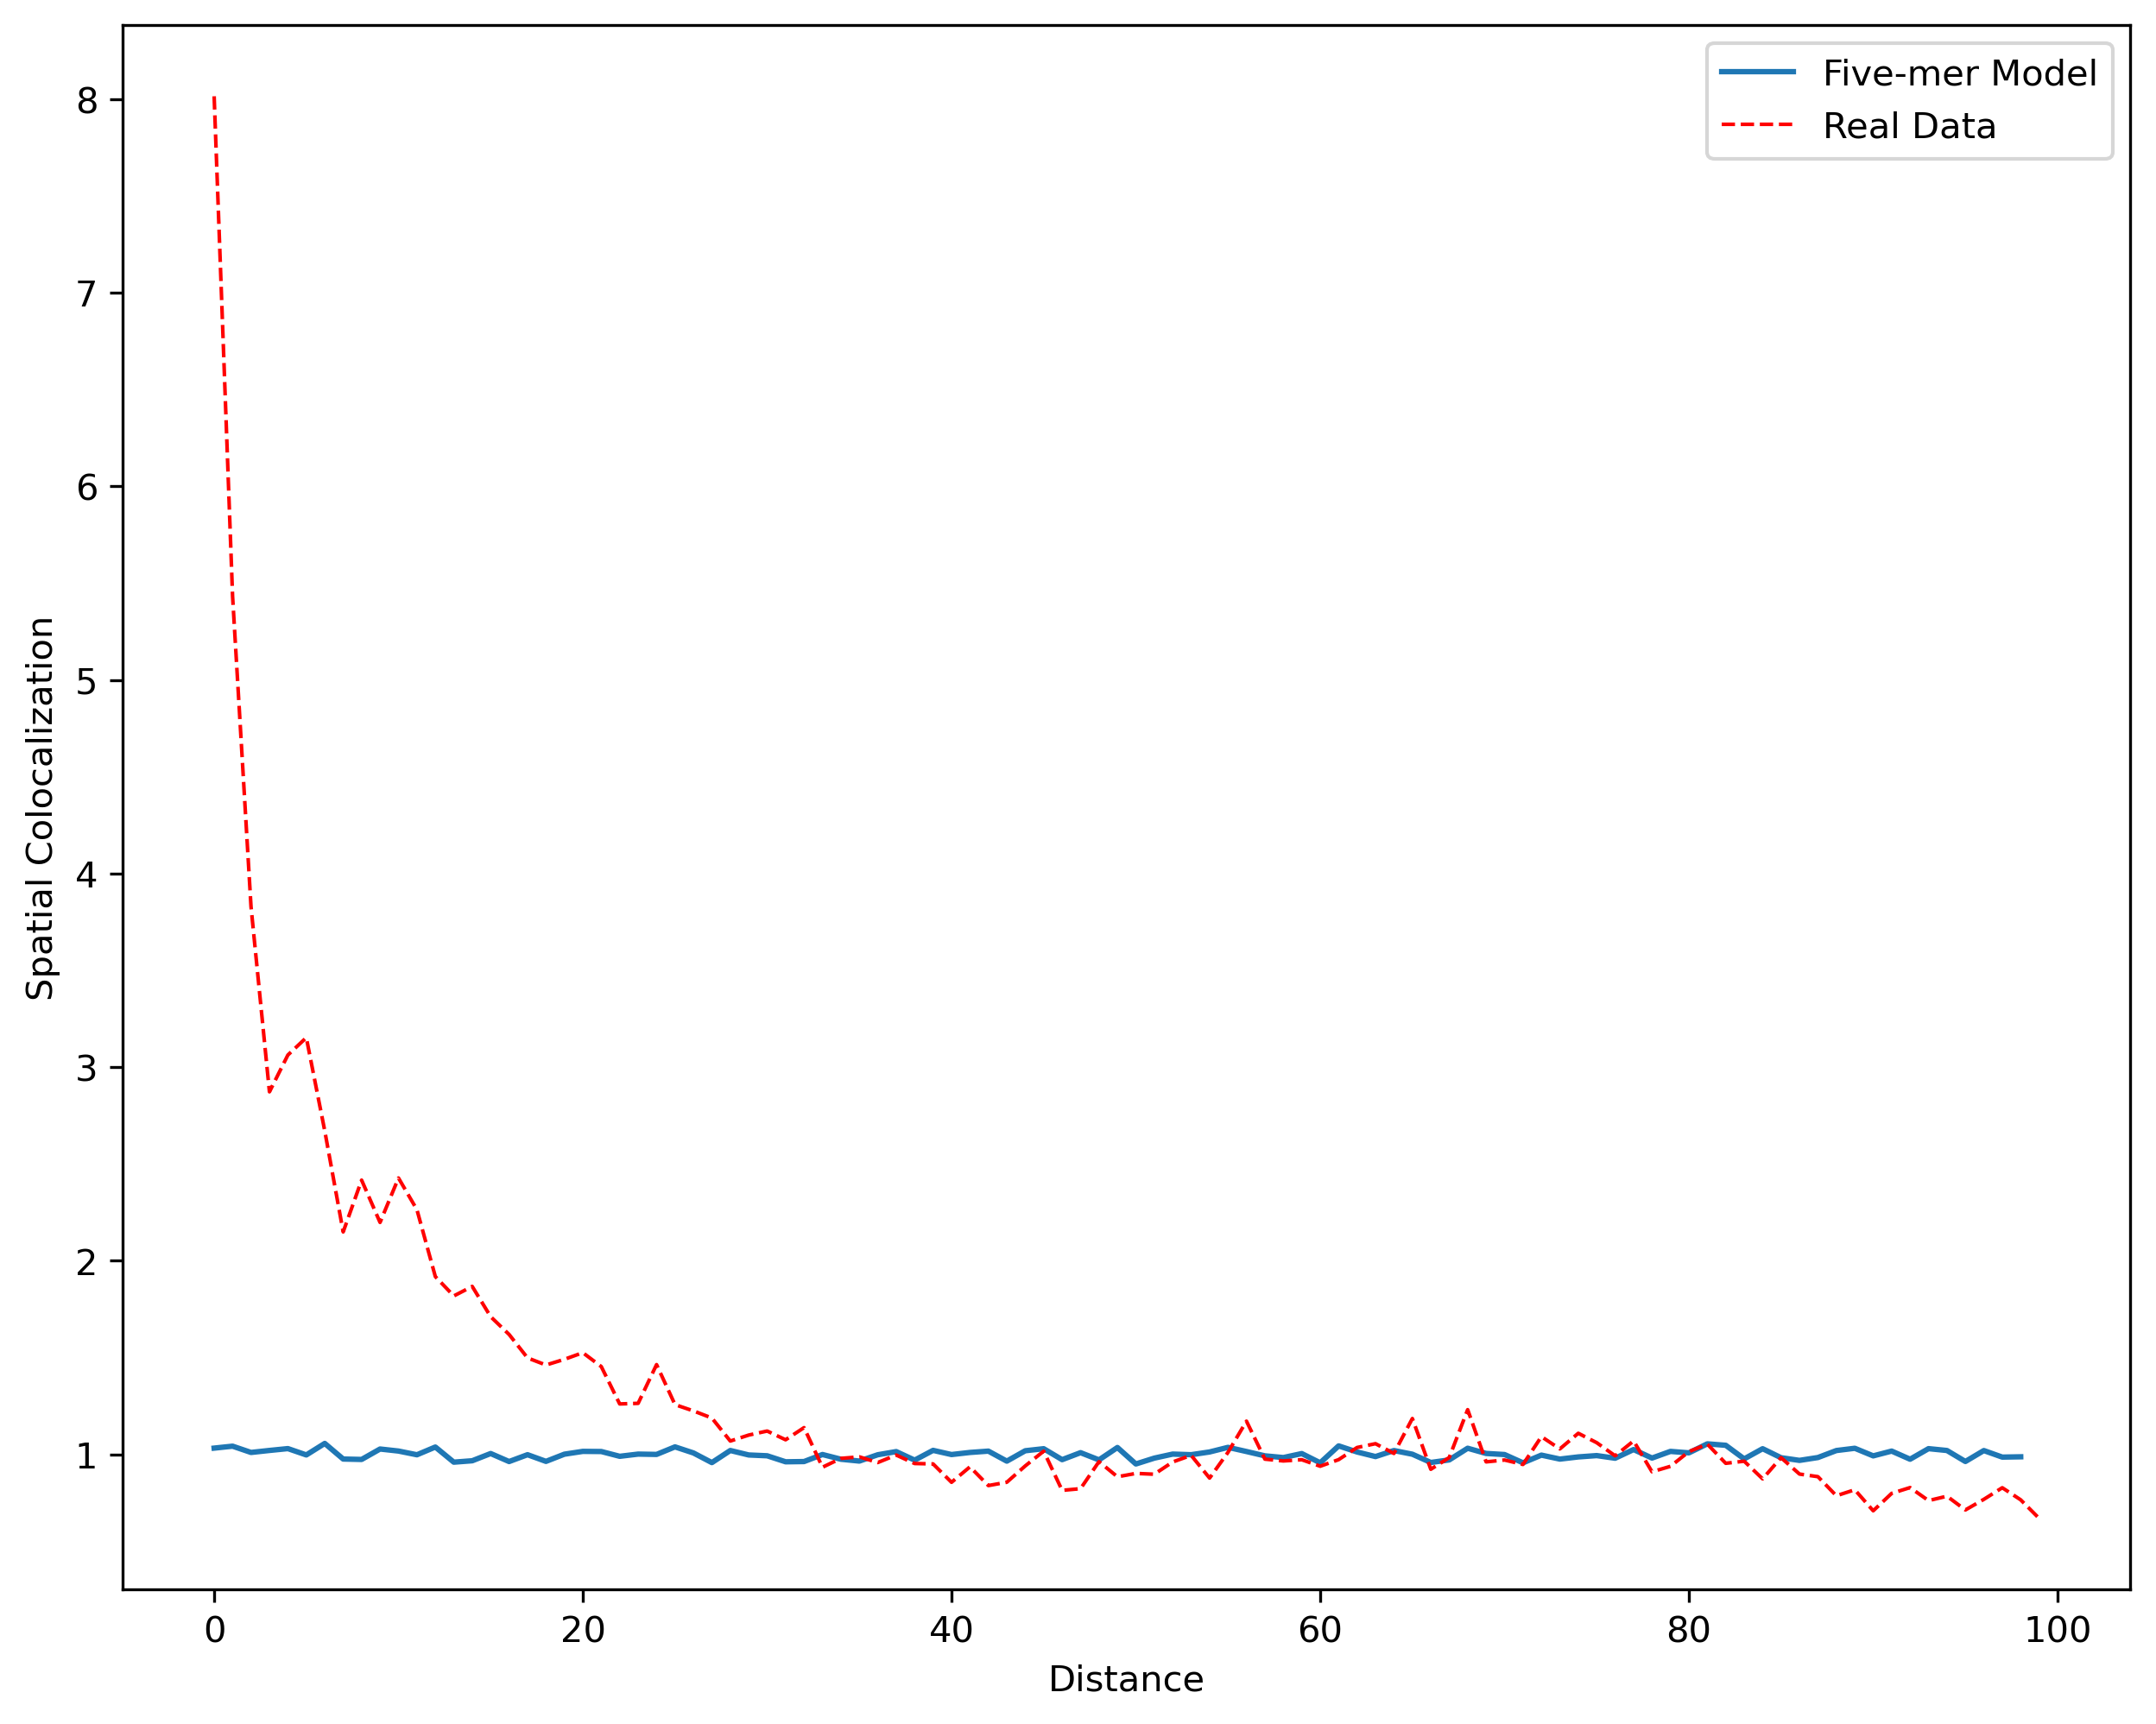

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8),dpi = 300)
plt.plot(num[1:]/deno[1:])
num_5mer = num[1:]
deno_5mer = deno[1:]
plt.plot(summ_stat[0:100], color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Distance')
plt.ylabel('Spatial Colocalization')
plt.legend(['Five-mer Model','Real Data'])

In [3]:
# Load our stuff
import tensorflow as tf
import numpy as np
from Bio import SeqIO
from SHMModels.simulate_mutations import *
from SHMModels.fitted_models import ContextModel
import pkgutil
import logging
import os
import sys
import json
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
random.seed(1408)
import csv
import collections
# Load options
import pandas as pd
import glob
import datetime
from random import sample
import csv
# Set lr
lr = 10e-6
# Load test and train data
data = []
with open("./sim_data/data/data.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        data.append(row)
data = [s for s in data if len(s) == 112]
data = np.array(data)

train_X = data[data[:,111]==0][:,0:105]
train_theta = data[data[:,111]==0][:,105:111]
test_X = data[data[:,111]==1][:,0:105]
test_theta = data[data[:,111]==1][:,105:111]

x_mean = np.mean(train_X, axis =0)
x_sd = np.std(train_X, axis =0)
mean = np.mean(train_theta, axis =0)
std = np.std(train_theta, axis =0)
# Center labels
train_cent = (train_theta - mean)/std
test_cent = (test_theta - mean)/std
# Center training data
train_X = (train_X-x_mean)/x_sd
test_X =  (test_X - x_mean)/x_sd
# Get length of training data
train_n = np.shape(train_X)[0]
# Define training generator
def genTraining(batch_size):
    while True:
        # Get training data for step
        ind = random.sample(range(train_n), batch_size)
        yield (
            train_X[ind,:],
            [
                train_cent[ind,:]
            ],
        )

# Define our NN
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, input_dim= 105, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(12, activation='linear'))
# Give summary of architecture
def meanAndVariance(y_true,y_pred) :
  """Loss function that has the values of the last axis in y_true 
  approximate the mean and variance of each value in the last axis of y_pred."""
  mean = y_pred[..., 0::2]
  variance = y_pred[..., 1::2]
  res = tf.math.square(mean - y_true) + tf.math.square(tf.math.exp(variance) - tf.math.square(mean - y_true))
  return tf.math.reduce_mean(res, axis=-1)
# Initialize optimizer with given step size
adam = tf.keras.optimizers.Adam(learning_rate = lr)
# Compile model w/ pinball loss, use mse as metric
model.compile(
    loss=[meanAndVariance],
    optimizer=adam,
)

log_dir = "logs/fits/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [4]:
history = model.fit(
    genTraining(1000),
    epochs=40000,
    steps_per_epoch=1,
    validation_data=(test_X, test_cent)
)


Epoch 1/40000


2024-06-23 21:10:14.164159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 2s 2s/step - loss: 5.6497 - val_loss: 5.4921
Epoch 2/40000
1/1 [==============================] - 0s 123ms/step - loss: 5.2777 - val_loss: 5.4606
Epoch 3/40000
1/1 [==============================] - 0s 143ms/step - loss: 5.5221 - val_loss: 5.4297
Epoch 4/40000
1/1 [==============================] - 0s 153ms/step - loss: 5.6495 - val_loss: 5.3993
Epoch 5/40000
1/1 [==============================] - 0s 108ms/step - loss: 5.6542 - val_loss: 5.3690
Epoch 6/40000
1/1 [==============================] - 0s 93ms/step - loss: 5.7651 - val_loss: 5.3389
Epoch 7/40000
1/1 [==============================] - 0s 101ms/step - loss: 5.3380 - val_loss: 5.3094
Epoch 8/40000
1/1 [==============================] - 0s 95ms/step - loss: 6.2286 - val_loss: 5.2799
Epoch 9/40000
1/1 [==============================] - 0s 96ms/step - loss: 5.4845 - val_loss: 5.2508
Epoch 10/40000
1/1 [==============================] - 0s 91ms/step - loss: 5.1084 - val_loss: 5.2224
Epoch 11/4

In [20]:
pred_labels = (model.predict(test_X))

 1/27 [>.............................] - ETA: 0s

27/27 [==============================] - 0s 2ms/step


In [6]:
test_mean = pred_labels[..., 0::2]
test_variance = pred_labels[..., 1::2]

In [7]:
pred_mean = (test_mean*std) + mean

In [8]:
pred_var = tf.math.exp(test_variance)*std

In [9]:
pred_var

<tf.Tensor: shape=(860, 6), dtype=float32, numpy=
array([[9.4582558e-02, 1.7621340e-01, 1.1026481e-02, 2.1487460e+00,
        1.9404459e+00, 1.1590395e-02],
       [2.3029611e-01, 3.2117361e-01, 2.1093309e-02, 2.5901141e+00,
        2.4410136e+00, 4.4607930e-03],
       [1.7810319e-02, 3.1337995e-02, 7.3745297e-03, 2.7236042e+00,
        2.9978027e+00, 1.9427909e-02],
       ...,
       [1.4359239e-01, 3.1240687e-01, 6.8139713e-03, 2.2949600e+00,
        1.9196211e+00, 2.1357681e-03],
       [3.2544804e-01, 2.8721184e-01, 1.5187763e-02, 2.9051516e+00,
        2.3077984e+00, 1.1283940e-02],
       [1.9426303e-01, 1.2622944e-01, 7.3976000e-03, 3.6540844e+00,
        2.5927689e+00, 4.9423845e-03]], dtype=float32)>

In [10]:
np.save('preds/labels_10',np.array(test_theta))
np.save('preds/mpreds_10', np.array(pred_mean))
np.save('preds/vpreds_10', np.array(pred_var))
model.save("preds/model10")

INFO:tensorflow:Assets written to: preds/model10/assets


INFO:tensorflow:Assets written to: preds/model10/assets


In [46]:
# Clear all previously registered custom objects
tf.keras.saving.get_custom_objects().clear()


# Upon registration, you can optionally specify a package or a name.
# If left blank, the package defaults to `Custom` and the name defaults to
# the class name.
@tf.keras.saving.register_keras_serializable(package="my_package", name="custom_fn")
def meanAndVariance(y_true,y_pred) :
  """Loss function that has the values of the last axis in y_true 
  approximate the mean and variance of each value in the last axis of y_pred."""
  mean = y_pred[..., 0::2]
  variance = y_pred[..., 1::2]
  res = tf.math.square(mean - y_true) + tf.math.square(tf.math.exp(ariance) - tf.math.square(mean - y_true))
  return tf.math.reduce_mean(res, axis=-1)

In [47]:
test_theta = np.load('preds/labels_10.npy')
pred_mean = np.load('preds/mpreds_10.npy')
pred_var = np.load('preds/vpreds_10.npy')
model = tf.keras.saving.load_model('preds/model10')

ValueError: Unknown optimizer: 'Custom>Adam'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [48]:
preds = np.array(pred_var)
labels = np.square(np.array((test_theta-pred_mean)))

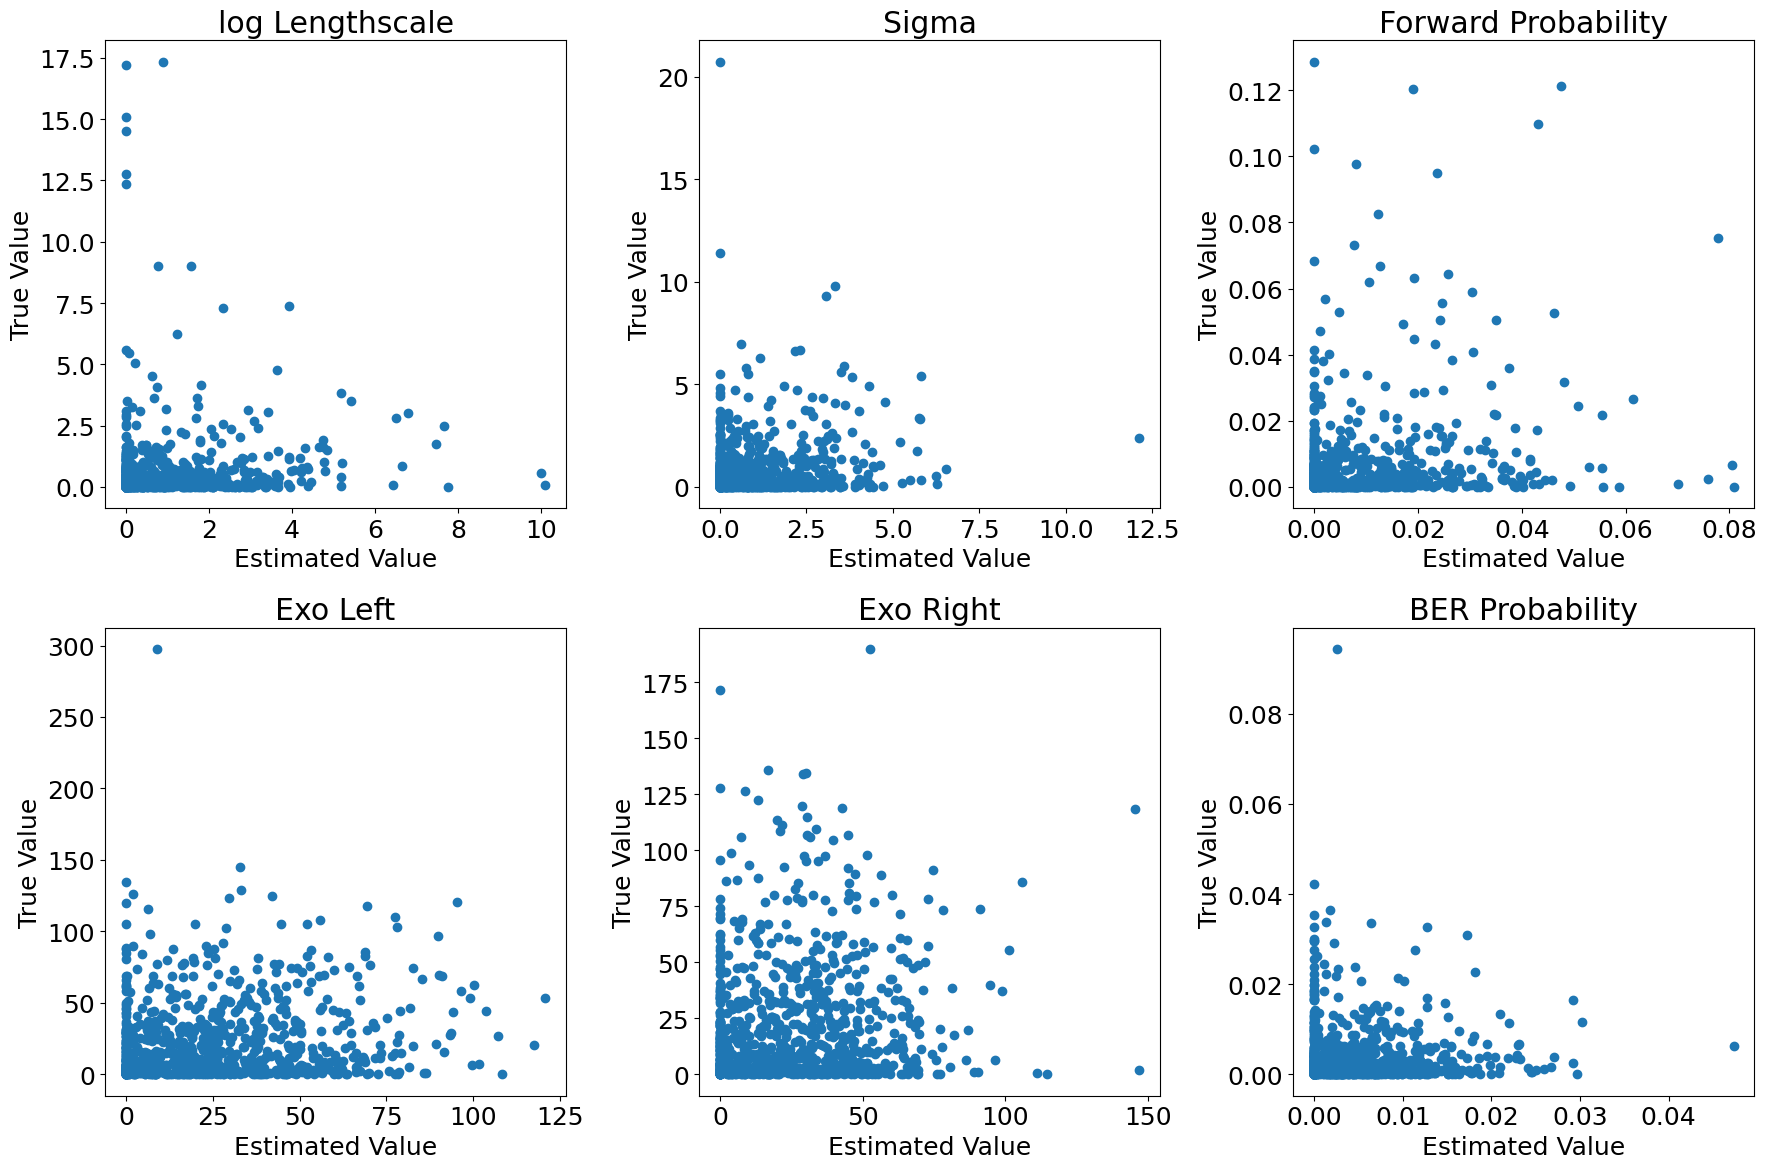

In [58]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 3)
  
# For Sine Function
axis[0, 0].scatter(preds[:,0], labels[:,0])
axis[0, 0].set_title("log Lengthscale")
axis[0, 0].set_xlabel("Estimated Value")
axis[0, 0].set_ylabel("True Value")
# For Cosine Function
axis[0, 1].scatter(preds[:,1], labels[:,1])
axis[0, 1].set_title("Sigma")
axis[0, 1].set_xlabel("Estimated Value")
axis[0, 1].set_ylabel("True Value")  
# For Tangent Function
axis[0, 2].scatter(preds[:,2], labels[:,2])
axis[0, 2].set_title("Forward Probability")
axis[0, 2].set_xlabel("Estimated Value")
axis[0, 2].set_ylabel("True Value")  
# For Sine Function
axis[1, 0].scatter(preds[:,3], labels[:,3])
axis[1, 0].set_title("Exo Left")
axis[1, 0].set_xlabel("Estimated Value")
axis[1, 0].set_ylabel("True Value")  
# For Cosine Function
axis[1, 1].scatter(preds[:,4], labels[:,4])
axis[1, 1].set_title("Exo Right")
axis[1, 1].set_xlabel("Estimated Value")
axis[1, 1].set_ylabel("True Value")  
# For Tangent Function
axis[1, 2].scatter(preds[:,5], labels[:,5])
axis[1, 2].set_title("BER Probability")
axis[1, 2].set_xlabel("Estimated Value")
axis[1, 2].set_ylabel("True Value")
figure.set_figheight(12)
figure.set_figwidth(18)
figure.tight_layout(pad=1.0)
# Combine all the operations and display
plt.savefig('figures/scatter_var.pdf', format = 'pdf')
plt.show()

In [50]:
var_means = np.mean(labels,axis = 0)

In [51]:
var_std = np.std(labels, axis = 0)

In [52]:
adj_pred_var = preds*(var_std/np.std(preds,axis = 0))

In [53]:
adj_pred_var = adj_pred_var + (np.mean(labels,axis =0)-np.mean(adj_pred_var,axis = 0))

In [54]:
preds = adj_pred_var
preds = np.maximum(0,preds)

In [28]:
[np.corrcoef(preds[i,:],labels[i,:]) for i in range(6)]

[array([[ 1.        , -0.39453068],
        [-0.39453068,  1.        ]]),
 array([[1.        , 0.85428111],
        [0.85428111, 1.        ]]),
 array([[1.        , 0.47487629],
        [0.47487629, 1.        ]]),
 array([[1.        , 0.98820466],
        [0.98820466, 1.        ]]),
 array([[1.        , 0.99923794],
        [0.99923794, 1.        ]]),
 array([[1.       , 0.1783242],
        [0.1783242, 1.       ]])]

In [31]:
np.mean(adj_pred_var, axis = 0)

array([6.18960337e-01, 8.20290603e-01, 7.29494965e-03, 2.24002547e+01,
       2.27633423e+01, 4.24225767e-03])

In [32]:
np.mean(labels,axis = 0)

array([6.18960337e-01, 8.20290603e-01, 7.29494965e-03, 2.24002547e+01,
       2.27633423e+01, 4.24225767e-03])

In [33]:
np.std(adj_pred_var,axis = 0)

array([1.65950490e+00, 1.43043282e+00, 1.47213446e-02, 2.69886299e+01,
       2.93370529e+01, 7.68796888e-03])

In [36]:
np.std(labels,axis =0)

array([1.65950490e+00, 1.43043282e+00, 1.47213446e-02, 2.69886299e+01,
       2.93370529e+01, 7.68796888e-03])